In [9]:
from multiprocessing import Process as Thread
from multiprocessing import Queue, Value
from time import perf_counter
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib as mpl

from channel import Channel
from GBN import Sender as SenderGBN, Receiver as ReceiverGBN
from SRP import Sender as SenderSRP, Receiver as ReceiverSRP

sns.set(color_codes=True)
mpl.rcParams['figure.dpi'] = 120

In [10]:
def plot(x, y, xlabel=None, ylabel=None, title=None, **kwargs):
    plt.plot(x, y, **kwargs)
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if title:
        plt.title(title)
        
def experiment(window_size, timeout, loss_chance):


    main_q = Queue()
    back_q = Queue()
    result = Queue()
    msgs = Value('i', 0)

    sender = Sender(msgs, window_size=window_size, timeout=timeout)
    receiver = Receiver(result)

    channel_main = Channel(main_q, loss_chance=loss_chance)
    channel_back = Channel(back_q, loss_chance=0)
    sender_thread = Thread(target=sender.run, args=(channel_back, channel_main, data, False))
    receiver_thread = Thread(target=receiver.run, args=(channel_main, channel_back, False))

    time_start = perf_counter()
    sender_thread.start()
    receiver_thread.start()
    sender_thread.join()
    receiver_thread.join()
    time_elapsed = perf_counter() - time_start

    r = []
    while not receiver.data.empty():
        r.append(receiver.data.get())

    assert (r == data)
    return msgs.value, time_elapsed

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

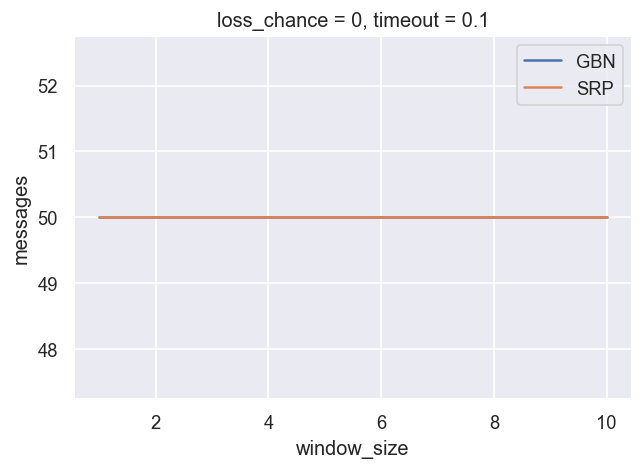

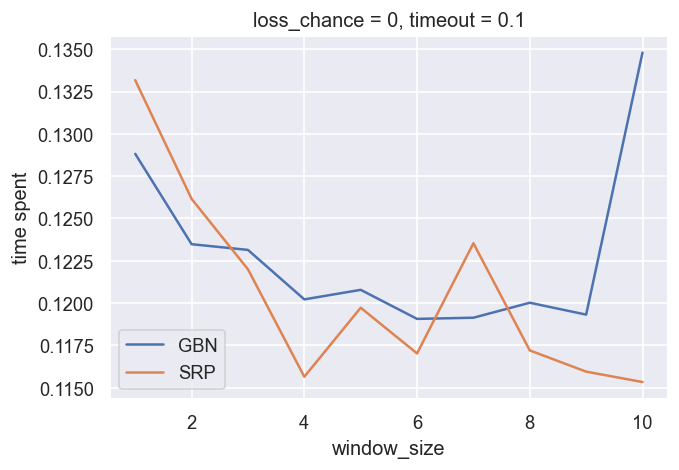

loss_chance = 0, timeout = 0.1


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

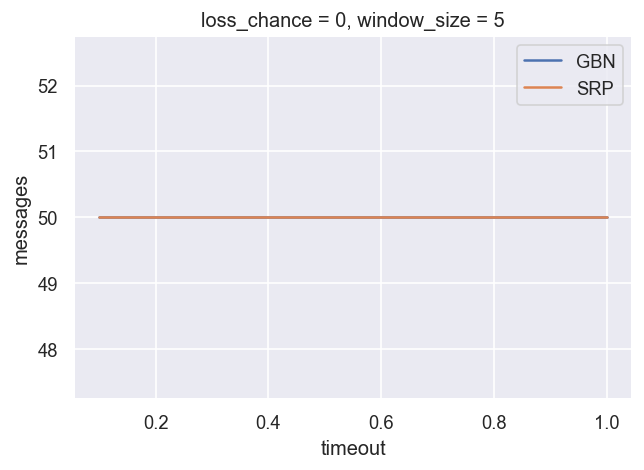

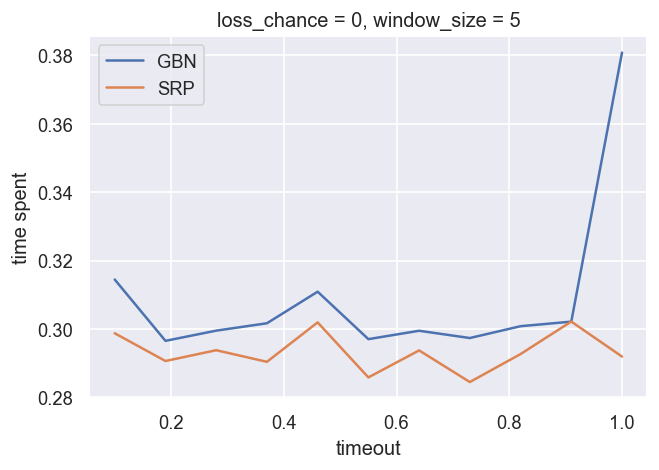

loss_chance = 0, window_size = 5


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

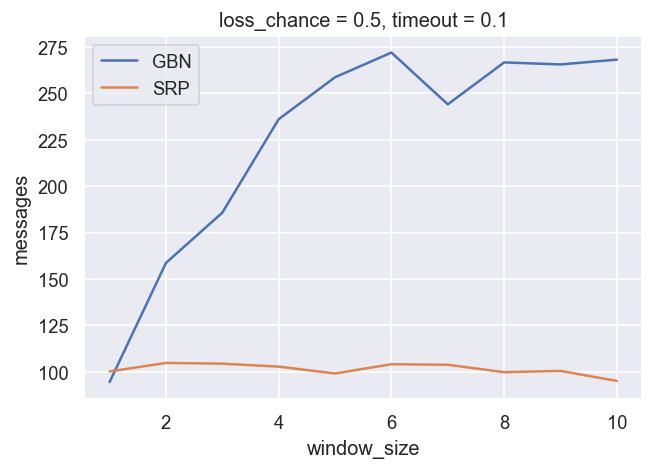

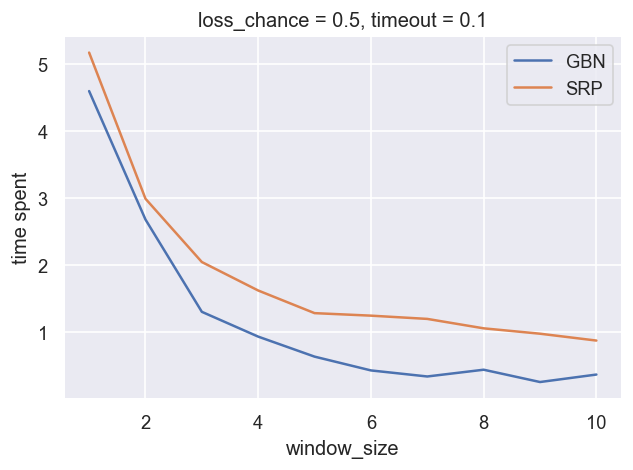

loss_chance = 0.5, timeout = 0.1


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

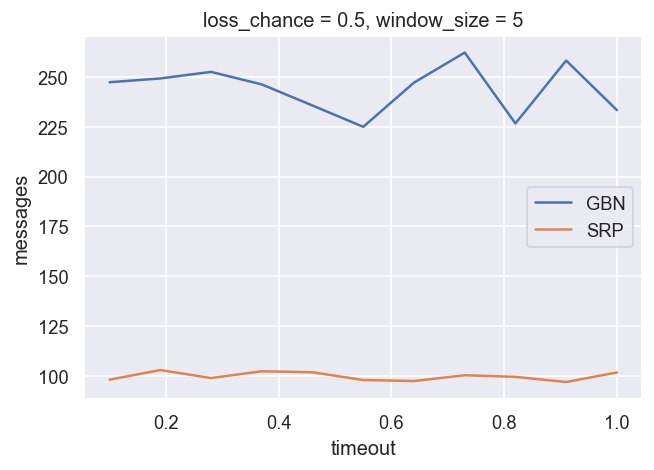

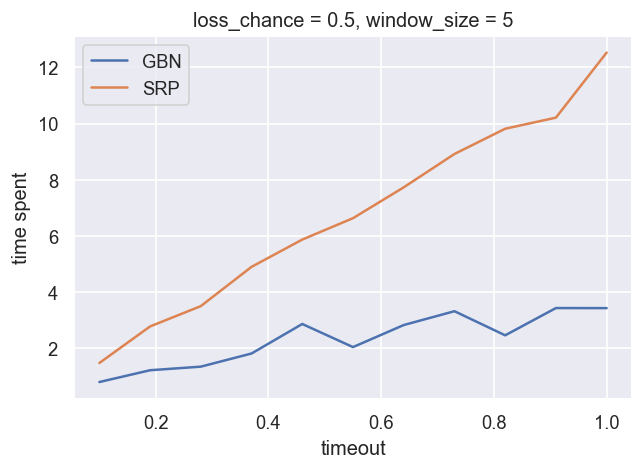

loss_chance = 0.5, window_size = 5


In [11]:
data = list(range(50))

N = 10

for loss_chance in tqdm([0, 0.5]):
    timeout = 0.1
    window_sizes = list(range(1, 11))
    msgs_sent = {}
    time_spent = {}
    
    for Sender, Receiver in (SenderSRP, ReceiverSRP), (SenderGBN, ReceiverGBN):
        protocol = 'GBN' if Sender == SenderGBN else 'SRP'
        msgs_sent[protocol] = []
        time_spent[protocol] = []
        
        for window_size in tqdm(window_sizes):
            msgs = []
            time_elapsed = []
            for _ in range(N):
                msgs_ex, time_elapsed_ex = experiment(window_size, timeout, loss_chance)
                msgs.append(msgs_ex)
                time_elapsed.append(time_elapsed_ex)
                
            msgs_sent[protocol].append(np.mean(msgs))
            time_spent[protocol].append(np.mean(time_elapsed))
            
    title = 'loss_chance = {}, timeout = {}'.format(loss_chance, timeout)
    
    plot(window_sizes, msgs_sent['GBN'], 'window_size', 'messages', title, label='GBN')
    plot(window_sizes, msgs_sent['SRP'], label='SRP')
    plt.legend()
    plt.show()

    plot(window_sizes, time_spent['GBN'], 'window_size', 'time spent', title, label='GBN')
    plot(window_sizes, time_spent['SRP'], label='SRP')
    plt.legend()
    plt.show()
    print(title)

    window_size = 5
    msgs_sent = {}
    time_spent = {}
    timeouts = np.linspace(0.1, 1, num=11)
    
    for Sender, Receiver in (SenderGBN, ReceiverGBN), (SenderSRP, ReceiverSRP):
        protocol = 'GBN' if Sender == SenderGBN else 'SRP'
        msgs_sent[protocol] = []
        time_spent[protocol] = []
        
        for timeout in tqdm(timeouts):
            msgs = []
            time_elapsed = []
            for _ in range(N):
                msgs_ex, time_elapsed_ex = experiment(window_size, timeout, loss_chance)
                msgs.append(msgs_ex)
                time_elapsed.append(time_elapsed_ex)
                
            msgs_sent[protocol].append(np.mean(msgs))
            time_spent[protocol].append(np.mean(time_elapsed))
            
    title = 'loss_chance = {}, window_size = {}'.format(loss_chance, window_size)

    plot(timeouts, msgs_sent['GBN'], 'timeout', 'messages', title, label='GBN')
    plot(timeouts, msgs_sent['SRP'], label='SRP')
    plt.legend()
    plt.show()

    plot(timeouts, time_spent['GBN'], 'timeout', 'time spent', title, label='GBN')
    plot(timeouts, time_spent['SRP'], label='SRP')
    plt.legend()
    plt.show()
    print(title)